In [137]:
import os
import numpy as np
import random
import torch
import time
import optuna
from train_dqn import fill_memory, train_dqn
%matplotlib inline

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [138]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [139]:
from envs.GraphEnv.impnode import ImpnodeEnv
import DQN_agent_modular

In [31]:
# variables for training the agent
def objective(trial):
    num_train_eps = 3000 
    num_mem_fill_eps = trial.suggest_int('num_mem_fill_eps', 500, 2000, 500)
    discount = 0.99 
    batch_size = trial.suggest_categorical('batch_size', [32,64,128]) 
    mem_capacity = trial.suggest_int('mem_capacity', 500, 2000, 500)  
    update_frequency = trial.suggest_int('update_frequency', 100, 500, 100) 
    eps_max = 1.0 
    eps_min = 0.05 
    eps_step = trial.suggest_int('update_frequency', 1000, 2000, 500)
    lr = trial.suggest_categorical('lr', [0.001,0.0001])
    alpha = trial.suggest_categorical('alpha', [0.001,0.01])
    
    gnn_depth=trial.suggest_categorical('gnn_depth', [3,4,5])
    state_size=2
    hidden_size1=trial.suggest_categorical('hidden_size1', [16,32,64])
    hidden_size2=trial.suggest_categorical('hidden_size2', [16,32,64])
    action_size=1
    n_step=3
    
    ba_nodes = (30, 50)
    ba_edges=4
    anc = 'dw_nd'
    max_removed_nodes = 4
    seed = None
    
    results_base_path_train = "results/hyp_search/{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
                               device, alpha, num_train_eps, num_mem_fill_eps, discount, batch_size, mem_capacity, update_frequency, eps_max, eps_min, eps_step, lr, gnn_depth, state_size, hidden_size1, hidden_size2, action_size, n_step, ba_nodes, ba_edges, anc, max_removed_nodes, seed)
    
    if not os.path.exists(results_base_path_train):
        os.makedirs(results_base_path_train)
    else:
        timestamp = time.strftime("%Y%m%d%H%M%S")
        new_directory = f"{results_base_path_train}_{timestamp}"
        os.makedirs(new_directory)
        results_base_path_train = new_directory
        print(f"Directory already exists. Created a new one: {new_directory}")
    
    
    env_train = ImpnodeEnv(anc=anc, 
                           ba_nodes=ba_nodes, 
                           ba_edges=ba_edges, 
                           max_removed_nodes=max_removed_nodes, 
                           seed=seed, 
                           render_option=False, 
                           mode='train')
    # create the dqn_agent
    dqn_agent_train = DQN_agent_modular.DQNAgent(device,
                                                 alpha=alpha,
                                                 gnn_depth=gnn_depth,
                                                 state_size=state_size,
                                                 hidden_size1=hidden_size1,
                                                 hidden_size2=hidden_size2,
                                                 action_size=action_size,
                                                 discount=discount,
                                                 eps_max=eps_max,
                                                 eps_min=eps_min,
                                                 eps_step=eps_step,
                                                 memory_capacity=mem_capacity,
                                                 lr=lr,
                                                 mode='train')
    
    
    fill_memory(env_train, dqn_agent_train, num_mem_fill_eps, n_step)
    
    avg_train = train_dqn(env_train, dqn_agent_train, results_base_path_train, num_train_eps, n_step, batch_size, update_frequency)
    return avg_train


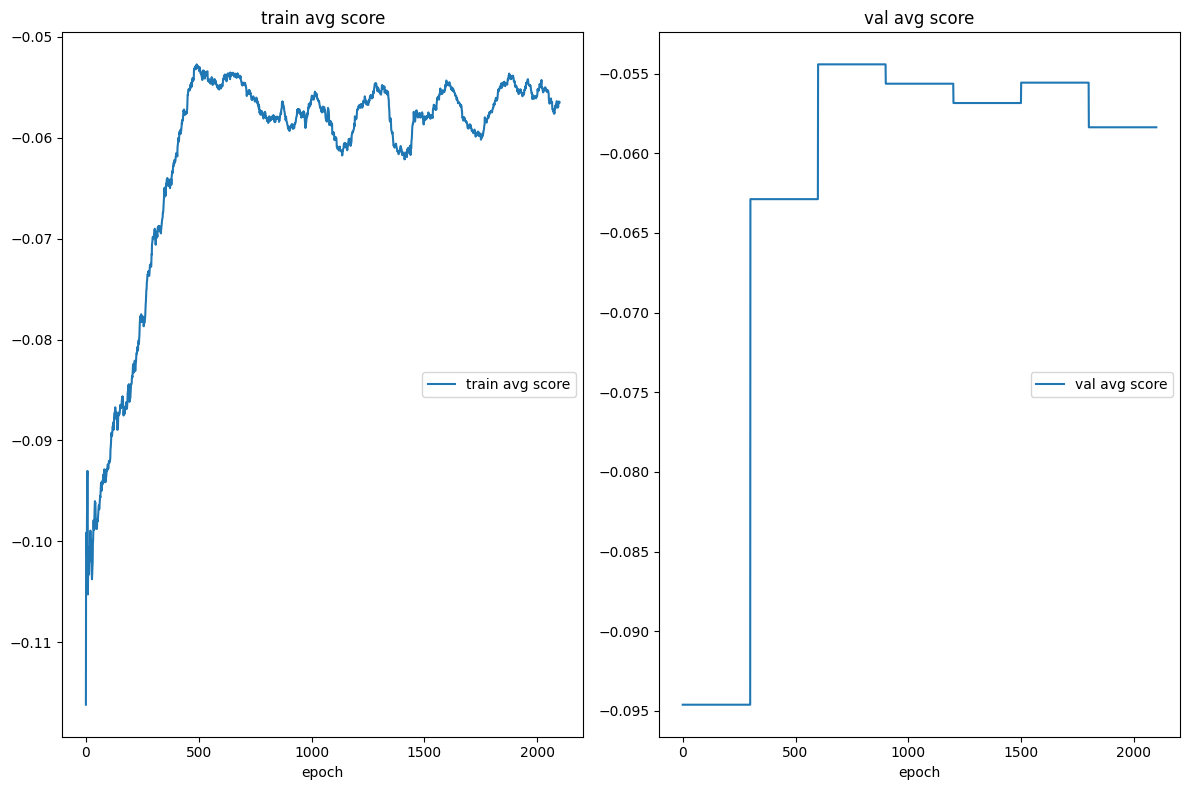

train avg score
	train avg score  	 (min:   -0.116, max:   -0.053, cur:   -0.056)
val avg score
	val avg score    	 (min:   -0.095, max:   -0.054, cur:   -0.058)


[I 2024-04-04 08:25:49,875] Trial 19 finished with value: -0.05682739179568555 and parameters: {'num_mem_fill_eps': 1000, 'batch_size': 64, 'mem_capacity': 1000, 'update_frequency': 400, 'lr': 0.0001, 'alpha': 0.001, 'gnn_depth': 4, 'hidden_size1': 64, 'hidden_size2': 32}. Best is trial 18 with value: -0.05404116920355548.


EarlyStopping counter: 5 out of 5
Early stopping


In [32]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

In [ ]:
print('done')

In [140]:
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
files = [str(f)+'\info.csv' for f in pathlib.Path('{}/results/hyp_search'.format(pathlib.Path.cwd())).iterdir() if f.is_dir()]

In [141]:
dataframes = []
for file in files:
    df = pd.read_csv(file) 
    
    df['source'] = file.split('\\')[-2]
    dataframes.append(df)

In [142]:
df_all = pd.concat(dataframes)
df_all

,ep_cnt,train_avg_score,val_avg_score,source
0,0,-0.116196,-0.094606,cuda_0.001_3000_1000_0.99_64_1000_400_1.0_0.05...
1,1,-0.099168,-0.094606,cuda_0.001_3000_1000_0.99_64_1000_400_1.0_0.05...
2,2,-0.101341,-0.094606,cuda_0.001_3000_1000_0.99_64_1000_400_1.0_0.05...
3,3,-0.100149,-0.094606,cuda_0.001_3000_1000_0.99_64_1000_400_1.0_0.05...
4,4,-0.100307,-0.094606,cuda_0.001_3000_1000_0.99_64_1000_400_1.0_0.05...
...,...,...,...,...
2995,2995,-0.057311,-0.051965,cuda_0.01_3000_500_0.99_32_2000_200_1.0_0.05_2...
2996,2996,-0.057269,-0.051965,cuda_0.01_3000_500_0.99_32_2000_200_1.0_0.05_2...
2997,2997,-0.057313,-0.051965,cuda_0.01_3000_500_0.99_32_2000_200_1.0_0.05_2...
2998,2998,-0.057291,-0.051965,cuda_0.01_3000_500_0.99_32_2000_200_1.0_0.05_2...


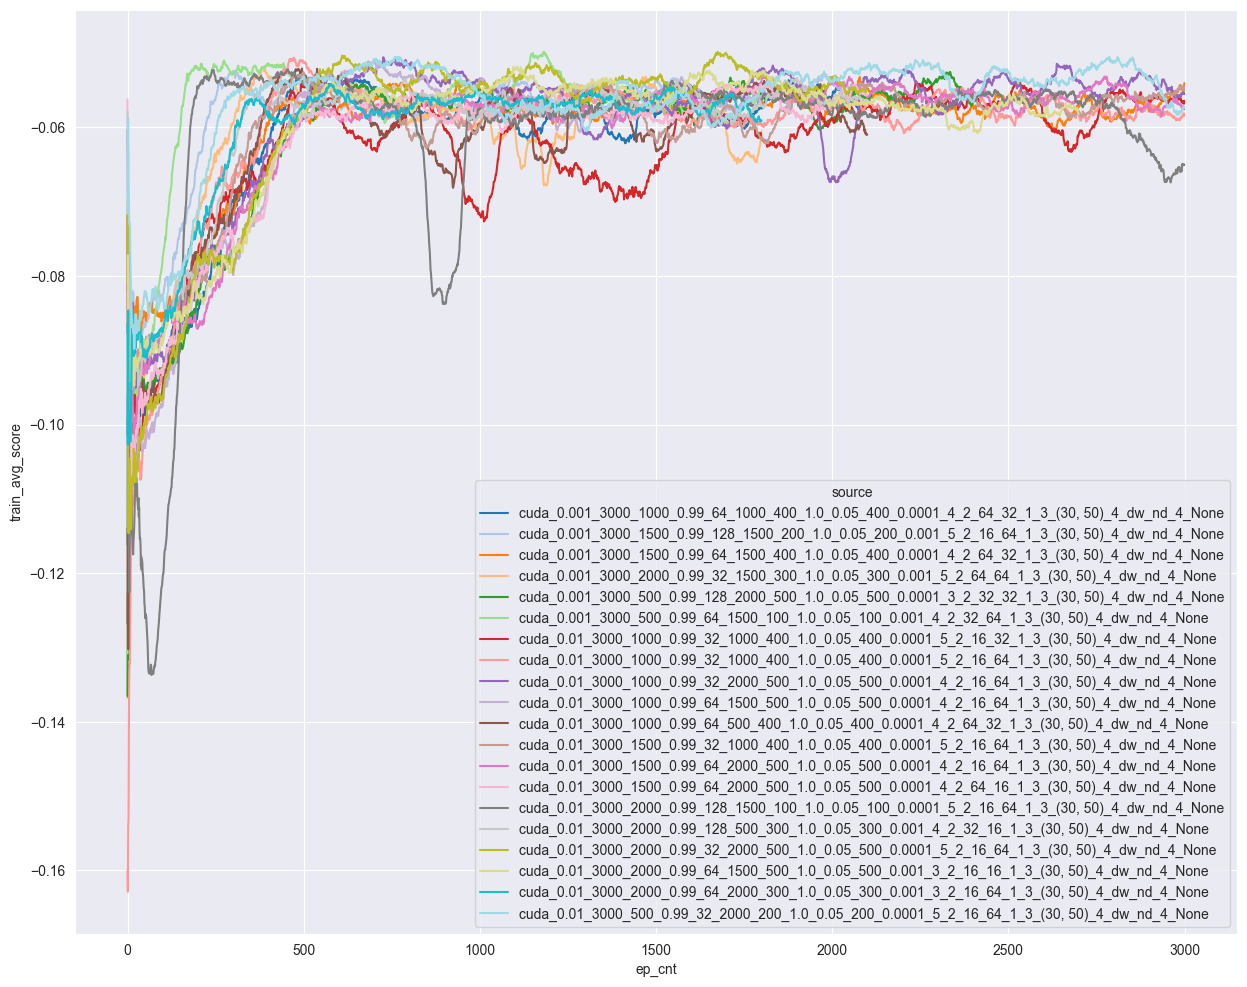

In [145]:
plt.figure(figsize=(15,12))
ax = sns.lineplot(df_all, y='train_avg_score', x='ep_cnt', hue='source', palette=sns.color_palette("tab20", 20))
sns.move_legend(ax, "lower right")